In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome


In [2]:
def get_robot(genome, robot_size, neat_config):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(robot_size)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, robot_size)
        print(robot)

    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)

    
    env = DynamicObstacleTraverser(body=robot, connections=connections, filename="../dynamic_env/env.json")
    img = env.render(mode='img')
    env.close()
    return robot, img

In [4]:
# STEPS = 400
# ROBOT_SIZE = 5
# POP = 48

# directory = "results/" + ENV

# params = {"robot_size": ROBOT_SIZE, "env": "dynamic", "steps": STEPS, "pop_size": POP}

# morphology_coords = morph_substrate(ROBOT_SIZE)
# CustomGenome.robot_func = lambda self, net, params: generate_robot(net, ROBOT_SIZE)
# CustomGenome.substrate = morphology_coords
# CustomGenome.robot_size = ROBOT_SIZE


# neat_config = neat.config.Config(
#     CustomGenome,
#     neat.reproduction.DefaultReproduction, 
#     neat.species.DefaultSpeciesSet, 
#     neat.stagnation.DefaultStagnation, 
#     "../neat_configs/POET.cfg"
# )

# input_size = morphology_coords.dimensions*2 + 1 # two coordinates plus the bias
# neat_config.genome_config.num_inputs = input_size
# neat_config.genome_config.input_keys = [-1*i for i in range(1, input_size+1)]
# neat_config.genome_config.num_outputs = 1
# neat_config.genome_config.output_keys = [1]

with open(f"../checkpoints/cp_5_CPPN_gen_225.pkl", "rb") as file:
    poet_pop = pkl.load(file)
    
CustomGenome.robot_func = lambda self, net, config: generate_robot(net, poet_pop.run_params.robot_size)
CustomGenome.substrate = morph_substrate(poet_pop.run_params.robot_size)
CustomGenome.robot_size = poet_pop.run_params.robot_size
CustomGenome.spec_genotype_weight = poet_pop.run_params.spec_genotype_weight
CustomGenome.spec_phenotype_weight = poet_pop.run_params.spec_phenotype_weight

In [6]:
def show_img(ag, min_fit, robot_size, neat_config):
    if ag.fitness is not None and ag.fitness > min_fit:
        r, img = get_robot(ag, robot_size, neat_config)
        if img is not None:
            print(ag.key, ag.fitness)
            plt.imshow(img)
            plt.show()
            net = neat.nn.FeedForwardNetwork.create(ag, neat_config)
            display(draw_net(net))




###################### Pair (env: 0, pop: 0) ########################

------------- Champion ----------------
6558 4.631562413695523


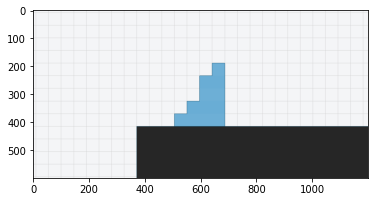

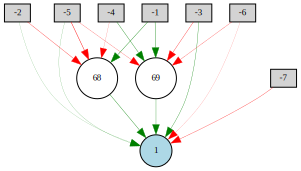



###################### Pair (env: 5, pop: 79) ########################

------------- Champion ----------------
8656 0.6877136585616778


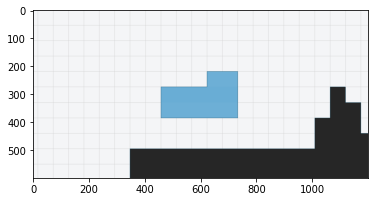

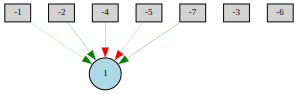



###################### Pair (env: 14, pop: 14) ########################

------------- Champion ----------------
6303 1.8668108578204743


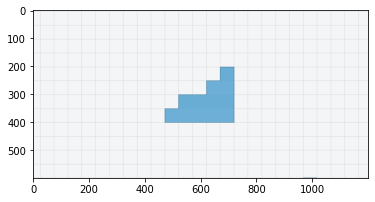

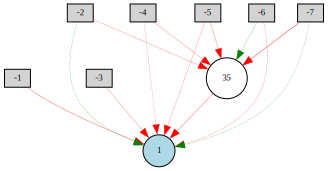



###################### Pair (env: 36, pop: 67) ########################

------------- Champion ----------------
8256 1.0299407755993832


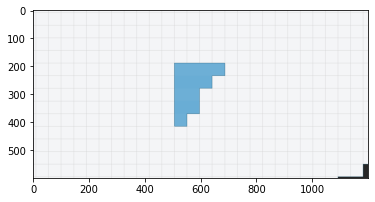

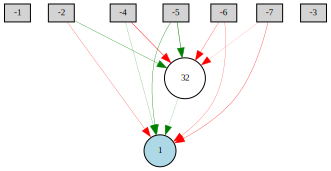



###################### Pair (env: 40, pop: 79) ########################

------------- Champion ----------------
7203 0.6793028422532459


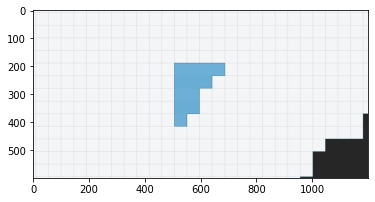

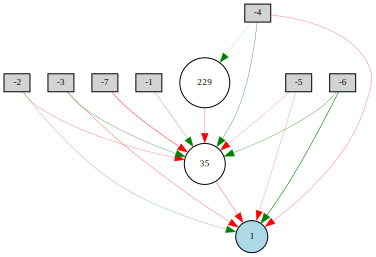



###################### Pair (env: 39, pop: 168) ########################

------------- Champion ----------------
9654 1.3141700251484152


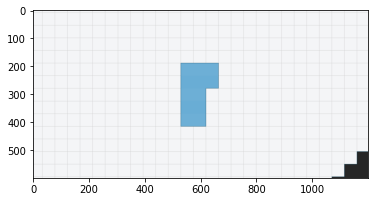

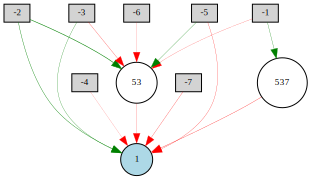



###################### Pair (env: 38, pop: 74) ########################

------------- Champion ----------------
7136 0.7536417078339184


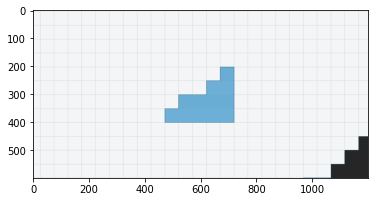

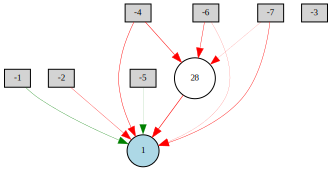



###################### Pair (env: 59, pop: 211) ########################

------------- Champion ----------------
10605 4.344020420885328


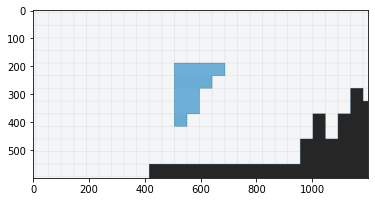

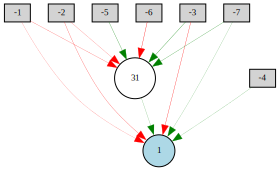



###################### Pair (env: 53, pop: 168) ########################

------------- Champion ----------------
9377 2.6048310097148253


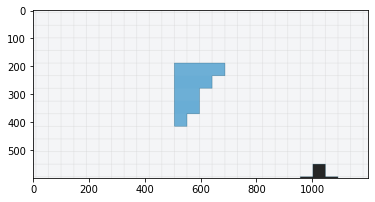

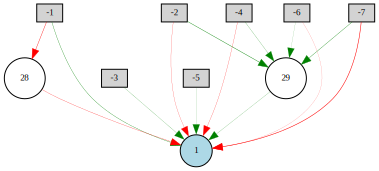



###################### Pair (env: 43, pop: 100) ########################

------------- Champion ----------------
8971 0.8231410071825314


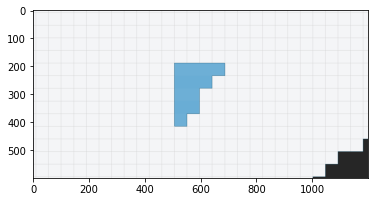

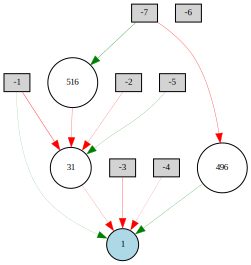



###################### Pair (env: 46, pop: 0) ########################

------------- Champion ----------------
6073 2.1089405618661914


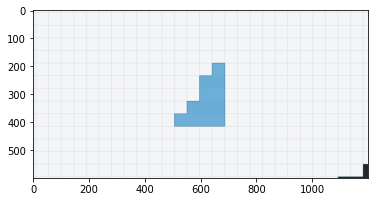

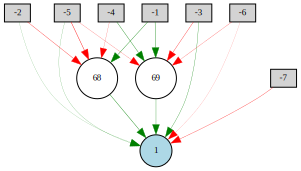



###################### Pair (env: 78, pop: 371) ########################

------------- Champion ----------------
12017 2.7449209007952167


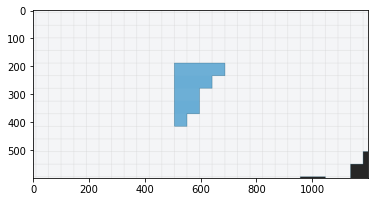

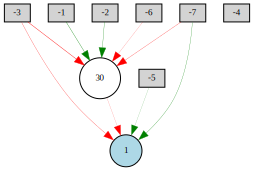



###################### Pair (env: 68, pop: 306) ########################

------------- Champion ----------------
10768 1.3204868271937755


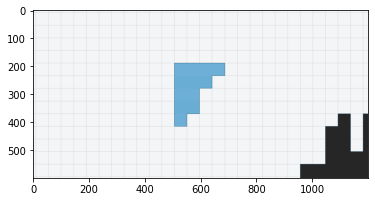

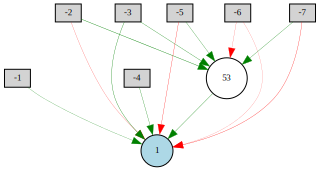



###################### Pair (env: 74, pop: 371) ########################

------------- Champion ----------------
11783 7.570718049066026


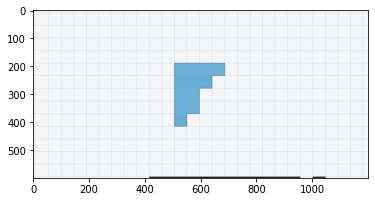

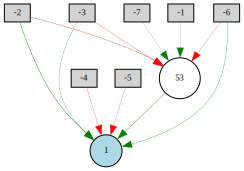



###################### Pair (env: 70, pop: 328) ########################

------------- Champion ----------------
10468 1.2738482971924


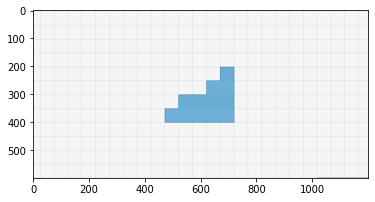

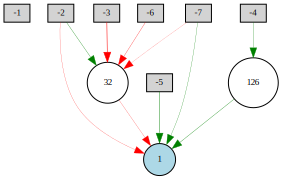



###################### Pair (env: 90, pop: 587) ########################

------------- Champion ----------------
12174 2.7263935222855085


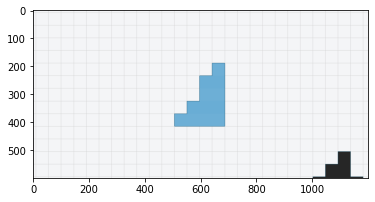

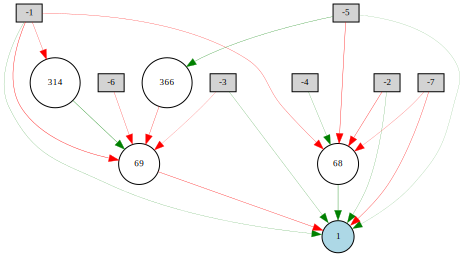



###################### Pair (env: 99, pop: 721) ########################

------------- Champion ----------------
6281 1.2039321003287369


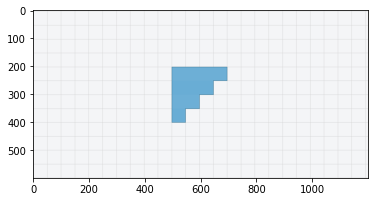

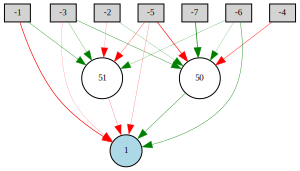



###################### Pair (env: 83, pop: 483) ########################

------------- Champion ----------------
10105 0.8567134401182863


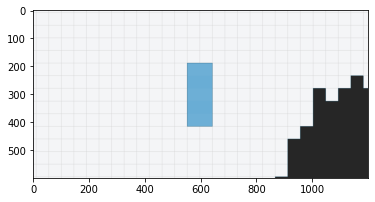

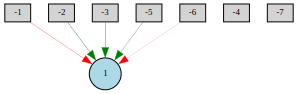



###################### Pair (env: 98, pop: 371) ########################

------------- Champion ----------------
11579 2.4362609752927797


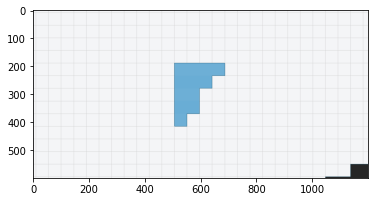

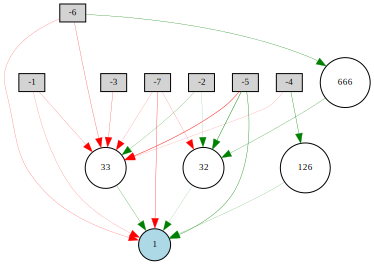

In [8]:
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    print(f"\n\n###################### Pair (env: {env.id}, pop: {pop.id}) ########################\n")
    env.generate_json("env.json")
    
    # for ag_id, ag in pop.pop.population.items():
    #     show_img(ag, 3, pop.robot_size, pop.neat_config)
    
    print("------------- Champion ----------------")
    show_img(pop.pop.best_genome, -1, pop.robot_size, pop.neat_config)

In [9]:
STEPS = 400
env_dict = {}
ag_dict = {}
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    for ag_id, ag in pop.pop.population.items():
        ag_dict[ag_id] = (ag, pop)
    env_dict[env.id] = env



In [10]:
def show_exec(ag_id, env_id):
    env_dict[env_id].generate_json("env.json")
    ag, pop = ag_dict[ag_id]
    reward, done = pop.single_genome_fit(ag, STEPS, "dynamic", True, None)
    return reward, done

In [18]:
r, d = show_exec(11579, 0)
print(r)

0.2475995363270534


In [17]:
env_id = 98
env1 = poet_pop.mutate(env_dict[env_id])
env2 = poet_pop.mutate(env_dict[env_id])

print(env_dict[env_id].obstacle_prob)
print(env1.obstacle_prob, env2.obstacle_prob)

[0.09 0.02 0.52 0.32 0.05]
[0.1  0.   0.45 0.45 0.  ] [0.06 0.16 0.47 0.27 0.04]


In [10]:
# poet_pop.create_environments()